# Preprocessing

## Load all data

In [3]:
sentences = []
topics = []
sentiments = []
datasets = []

for dataset in ['train', 'valid', 'test']:
    with open(f"data/{dataset}-sentences.txt", "r") as f:
        texts = [sen.strip() for sen in f.readlines()]
        sentences.extend(texts)
    with open(f"data/{dataset}-topics.txt", "r") as f:
        topics.extend(list(map(lambda x: int(x.strip()), f.readlines())))
    with open(f"data/{dataset}-sentiments.txt", "r") as f:
        sentiments.extend(list(map(lambda x: int(x.strip()), f.readlines())))
    datasets.extend([dataset]*len(texts))


In [4]:
import pandas as pd

df = pd.DataFrame({
    "sentence": sentences,
    "topic": topics,
    "sentiment": sentiments,
    "dataset": datasets
})

df.head()

,sentence,topic,sentiment,dataset
0,slide giáo trình đầy đủ .,1,2,train
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",0,2,train
2,đi học đầy đủ full điểm chuyên cần .,1,0,train
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0,train
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",0,2,train


Note:
- sentiment: Sentiment class, with values 0 (negative), 1 (neutral) and 2 (positive).
- topic: Topic class, with values 0 (lecturer), 1 (training program), 2 (facility) and 3 (others).

In [5]:
print(f"Number of samples in each set:")
print(df['dataset'].value_counts())
print(f"Total number of data samples: {len(df)}")

Number of samples in each set:
dataset
train    11426
test      3166
valid     1583
Name: count, dtype: int64
Total number of data samples: 16175


## Preprocessing sentences

In [6]:
# Get the list of Vietnamese stopwords
import requests

url = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/refs/heads/master/vietnamese-stopwords-dash.txt"
response = requests.get(url)

if response.status_code == 200:
    stopwords = response.text.splitlines()
    print("Downloaded successfully.")
    print(f"Number of stopwords: {len(stopwords)}")
    print(f"Some stopwords: {stopwords[:10]}")
else:
    print(f"Failed to download. Status code: {response.status_code}")

Downloaded successfully.
Number of stopwords: 1942
Some stopwords: ['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']


In [7]:
from typing import List
import re
from pyvi import ViTokenizer

def preprocess_text(sen: str) -> List[str]:
    """
    Apply the following operations on each sentence:
    - Convert to lowercase
    - Remove punctuation marks
    - Tokenize the sentence
    - Remove stopwords
    """
    # Convert to lowercase
    sen = sen.lower()

    # Remove punctuation marks
    sen = re.sub(r'[^\w\s]', '', sen)

    # Tokenize using pyvi
    tokens = ViTokenizer.tokenize(sen).split()

    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords]
    
    return tokens

In [8]:
df["tokens"] = df["sentence"].apply(preprocess_text)
df.head()

,sentence,topic,sentiment,dataset,tokens
0,slide giáo trình đầy đủ .,1,2,train,"[slide, giáo_trình, đầy_đủ]"
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",0,2,train,"[nhiệt_tình, giảng_dạy, gần_gũi, sinh_viên]"
2,đi học đầy đủ full điểm chuyên cần .,1,0,train,"[đi, học, đầy_đủ, full, chuyên_cần]"
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0,train,"[áp_dụng, công_nghệ, thông_tin, thiết_bị, giản..."
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",0,2,train,"[thầy, giảng, bài_tập, ví_dụ, lớp]"


In [9]:
# Save to file
df.to_csv("data/preprocessed_data.csv", index=False)

# EDA

In [10]:
import pandas as pd
import ast

# Reload the processed data
df = pd.read_csv("data/preprocessed_data.csv")
df["tokens"] = df["tokens"].apply(ast.literal_eval) # Fix tokens interpreted as a single string

df_train = df[df['dataset'] == 'train']
df_train.head()

,sentence,topic,sentiment,dataset,tokens
0,slide giáo trình đầy đủ .,1,2,train,"[slide, giáo_trình, đầy_đủ]"
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",0,2,train,"[nhiệt_tình, giảng_dạy, gần_gũi, sinh_viên]"
2,đi học đầy đủ full điểm chuyên cần .,1,0,train,"[đi, học, đầy_đủ, full, chuyên_cần]"
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0,train,"[áp_dụng, công_nghệ, thông_tin, thiết_bị, giản..."
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",0,2,train,"[thầy, giảng, bài_tập, ví_dụ, lớp]"


Note: Perform EDA on the train set only (valid and test sets are supposed to be unknown)

In [11]:
print("Count the number of responses grouped by topic and sentiment")

df_top_sent = df_train.groupby(['topic', 'sentiment']).size().reset_index(name='count') \
    .sort_values(by=['topic', 'sentiment'])
print(df_top_sent)

Count the number of responses grouped by topic and sentiment
    topic  sentiment  count
0       0          0   2909
1       0          1    186
2       0          2   5071
3       1          0   1716
4       1          1    101
5       1          2    384
6       2          0    474
7       2          1     10
8       2          2     13
9       3          0    226
10      3          1    161
11      3          2    175


In [12]:
import numpy as np

top_sent_mat = np.array(df_top_sent['count']).reshape(4, 3)
print(top_sent_mat)

[[2909  186 5071]
 [1716  101  384]
 [ 474   10   13]
 [ 226  161  175]]


## Visualization

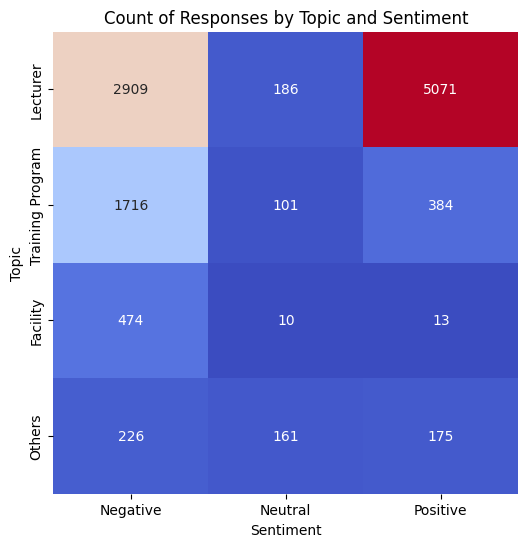

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(top_sent_mat, annot=True, fmt='d', cmap='coolwarm', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Lecturer', 'Training Program', 'Facility', 'Others'])
plt.title("Count of Responses by Topic and Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Topic")
plt.show()

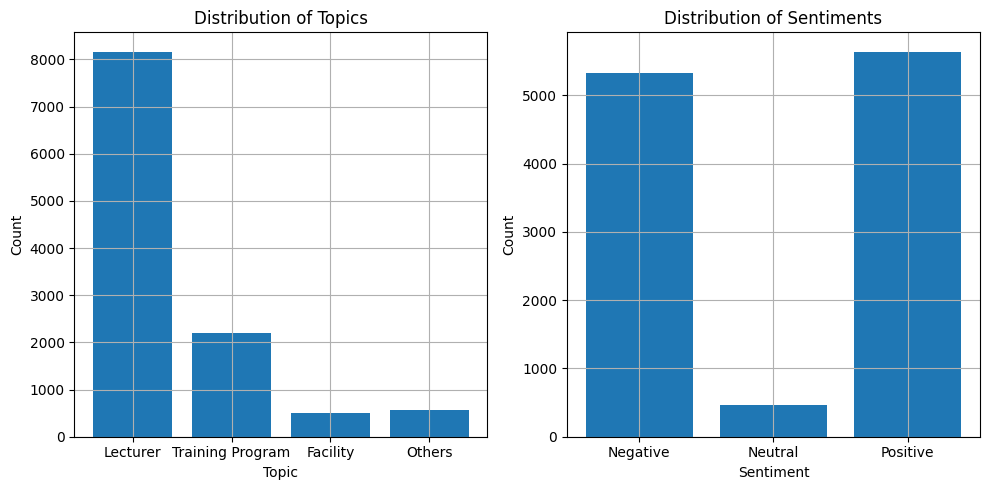

In [14]:
# Bar plot for topics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
topic_counts = df_train['topic'].value_counts().sort_index()
plt.bar(['Lecturer', 'Training Program', 'Facility', 'Others'], topic_counts)
plt.title('Distribution of Topics')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.grid('-')

# Bar plot for sentiments
plt.subplot(1, 2, 2)
sentiment_counts = df_train['sentiment'].value_counts().sort_index()
plt.bar(['Negative', 'Neutral', 'Positive'], sentiment_counts)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid('-')

plt.tight_layout()
plt.show()

## Word frequency analysis

In [15]:
from collections import Counter

for label, sent in zip(range(3), ['Negative', 'Neutral', 'Positive']):
    print(f"\nAnalyzing word frequencies for sentiment: {sent}")
    # Count word frequencies
    word_counts = Counter()
    for tokens in df_train[df_train.sentiment == label]['tokens']:
        word_counts.update(tokens)

    # Get the most common words
    most_common_words = word_counts.most_common(10)
    
    print(f"Most common words in training set (sentiment {sent}):")
    for word, count in most_common_words:
        print(f"{word}: {count}")


Analyzing word frequencies for sentiment: Negative
Most common words in training set (sentiment Negative):
sinh_viên: 1314
thầy: 1168
học: 917
thực_hành: 712
dạy: 688
giảng_viên: 679
bài_tập: 624
môn_học: 496
giảng: 465
lớp: 386

Analyzing word frequencies for sentiment: Neutral
Most common words in training set (sentiment Neutral):
thầy: 93
học: 47
sinh_viên: 34
bài_tập: 32
ý_kiến: 29
dạy: 28
thực_hành: 27
lớp: 25
giảng_viên: 24
môn: 20

Analyzing word frequencies for sentiment: Positive
Most common words in training set (sentiment Positive):
thầy: 1812
nhiệt_tình: 1741
dạy: 1445
sinh_viên: 1332
giảng_viên: 906
giảng_dạy: 671
giảng: 626
kiến_thức: 554
tận_tâm: 539
bài_tập: 392


# Split train - valid - test again

In [16]:
# Calculate original train - valid - test split sizes
train_size = len(df[df['dataset'] == 'train'])/len(df)
valid_size = len(df[df['dataset'] == 'valid'])/len(df)
test_size = len(df[df['dataset'] == 'test'])/len(df)

print(f"Original train size: {train_size:.2f}%")
print(f"Original valid size: {valid_size:.2f}%")
print(f"Original test size: {test_size:.2f}%")

Original train size: 0.71%
Original valid size: 0.10%
Original test size: 0.20%


In [17]:
from sklearn.model_selection import train_test_split

df_resplit = df.drop(columns=['dataset'])
df_resplit['composite'] = df_resplit['topic'].astype(str) + '_' + df_resplit['sentiment'].astype(str)

new_train, new_test = train_test_split(df_resplit, test_size=0.2, random_state=42, stratify=df_resplit['composite'])
new_train, new_valid = train_test_split(new_train, test_size=0.125, random_state=42, stratify=new_train['composite'])

print(f"Number of samples in each set after resplit:")
print(f"New Train: {len(new_train)}")
print(f"New Valid: {len(new_valid)}")
print(f"New Test: {len(new_test)}")

Number of samples in each set after resplit:
New Train: 11322
New Valid: 1618
New Test: 3235


In [18]:
# Concat new splits
new_train['dataset'] = 'train'
new_valid['dataset'] = 'valid'
new_test['dataset'] = 'test'
new_df = pd.concat([new_train, new_valid, new_test], ignore_index=True).drop(columns=['composite'])

new_df.head()

,sentence,topic,sentiment,tokens,dataset
0,"dạy dễ hiểu , thân thiện .",0,2,"[dạy, thân_thiện]",train
1,"giáo viên thực hành cần năng động hơn , thầy c...",0,0,"[giáo_viên, thực_hành, năng_động, thầy, vẻ, hơ...",train
2,giảng viên cần doubledot cho bài tập thêm về n...,0,0,"[giảng_viên, doubledot, bài_tập, ngữ_pháp]",train
3,thầy dạy tốt và rất nhiệt tình .,0,2,"[thầy, dạy, nhiệt_tình]",train
4,em rất hài lòng về phương pháp dạy này .,0,2,"[hài_lòng, phương_pháp, dạy]",train


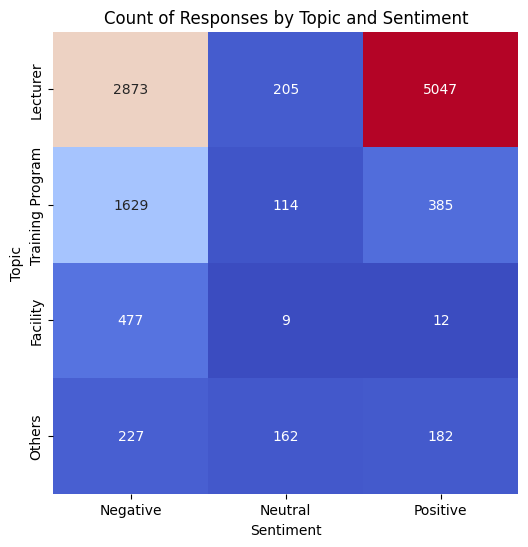

In [21]:
# Visualize the label distribution in the new train set

df_top_sent = new_train.groupby(['topic', 'sentiment']).size().reset_index(name='count') \
    .sort_values(by=['topic', 'sentiment'])
top_sent_mat = np.array(df_top_sent['count']).reshape(4, 3)

plt.figure(figsize=(6, 6))
sns.heatmap(top_sent_mat, annot=True, fmt='d', cmap='coolwarm', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Lecturer', 'Training Program', 'Facility', 'Others'])
plt.title("Count of Responses by Topic and Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Topic")
plt.show()


In [19]:
# Save the new split to CSV
new_df.to_csv("data/resplitted_data.csv")